In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [3]:
df = pd.read_csv("VENDOR_MASTER.csv", sep=";")
df.head()

,VENDORS,CREATIONS_Creations 2025,CREATIONS_Creations 2024,CREATIONS_Creations 2023,CREATIONS_TOTAL,NET SALES BILLED_NSB (H1 2025),NET SALES BILLED_NSB (FY2024),NET SALES BILLED_Total Sales (24/25?),NET SALES BILLED_NSB/Creation,BDOs and BU SPLIT_Distribution Model,...,MAVERICK_Rank,MAVERICK_Weight NSB BU,MAVERICK_Weight NSB Total,MAVERICK_Gross Margin,GCC_NSB YTD June FY25,GCC_Rank,GCC_Weight NSB BU,GCC_Weight NSB Total,GCC_Gross Margin,SCORE
0,HP INC,118312,141550,189735,449597,1060670973,1756117043,2816788016,"10839,55",Central,...,5,"0,04",0,"0,11",0,22,0,0,0,"15,44"
1,APPLE,26046,78124,69075,173245,2950116778,4758286630,7708403408,"73998,3",Local,...,22,0,0,0,0,22,0,0,0,"15,34"
2,HP ENT,15206,30575,30177,75958,845496353,1129480608,1974976961,"43139,66",Local,...,22,0,0,0,128,22,0,0,"0,09","8,9"
3,LENOVO,64376,61361,46548,172285,835691904,1560285784,2395977688,"19055,47",Local,...,6,"0,04",0,"0,09",0,22,0,0,0,"8,72"
4,CISCO,57734,98828,147445,304007,435871896,827326140,1263198036,"8068,36",Central,...,22,0,0,0,0,22,0,0,0,"8,59"


In [4]:
numeric_cols_to_fix = [
    'BDOs and BU SPLIT_AS ',
    'BDOs and BU SPLIT_EPS',
    'BDOs and BU SPLIT_SPS',
    'BDOs and BU SPLIT_S&C',
    'BDOs and BU SPLIT_Other',
    'TOTAL_Weight NSB Total',
    'TOTAL_Gross Margin',
    'ADVANCED SOLUTIONS_Weight NSB BU',
    'ADVANCED SOLUTIONS_Weight NSB Total',
    'ADVANCED SOLUTIONS_Gross Margin',
    'ENDPOINT SOLUTIONS_Weight NSB BU',
    'ENDPOINT SOLUTIONS_Weight NSB Total',
    'ENDPOINT SOLUTIONS_Gross Margin',
    'MAVERICK_Weight NSB BU',
    'MAVERICK_Weight NSB Total',
    'MAVERICK_Gross Margin',
    'GCC_Weight NSB BU',
    'GCC_Weight NSB Total',
    'GCC_Gross Margin',
    'SCORE'
]

for col in numeric_cols_to_fix:
    if df[col].dtype == 'O':
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric_cols_to_fix].dtypes


BDOs and BU SPLIT_AS                   float64
BDOs and BU SPLIT_EPS                  float64
BDOs and BU SPLIT_SPS                  float64
BDOs and BU SPLIT_S&C                  float64
BDOs and BU SPLIT_Other                float64
TOTAL_Weight NSB Total                 float64
TOTAL_Gross Margin                     float64
ADVANCED SOLUTIONS_Weight NSB BU       float64
ADVANCED SOLUTIONS_Weight NSB Total    float64
ADVANCED SOLUTIONS_Gross Margin        float64
ENDPOINT SOLUTIONS_Weight NSB BU       float64
ENDPOINT SOLUTIONS_Weight NSB Total    float64
ENDPOINT SOLUTIONS_Gross Margin        float64
MAVERICK_Weight NSB BU                 float64
MAVERICK_Weight NSB Total                int64
MAVERICK_Gross Margin                  float64
GCC_Weight NSB BU                      float64
GCC_Weight NSB Total                   float64
GCC_Gross Margin                       float64
SCORE                                  float64
dtype: object

In [5]:
int_cols = df.select_dtypes(include=['int64']).columns

df[int_cols] = df[int_cols].astype('float64')

col = 'NET SALES BILLED_NSB/Creation'

df[col] = (
    df[col]
    .astype(str)              
    .str.replace(',', '.', regex=False)
    .replace('', '0')        
)

df[col] = pd.to_numeric(df[col], errors='coerce')
categorical_people = [
    'BDOs and BU SPLIT_Silvia',
    'BDOs and BU SPLIT_Arnau',
    'BDOs and BU SPLIT_Dani',
    'BDOs and BU SPLIT_BDOs'
]

for col in categorical_people:
    df[col] = df[col].astype('object')
    categorical_people = [
    'BDOs and BU SPLIT_Silvia',
    'BDOs and BU SPLIT_Arnau',
    'BDOs and BU SPLIT_Dani',
    'BDOs and BU SPLIT_BDOs'
]

for col in categorical_people:
    df[col] = df[col].astype('object')

pd.set_option('display.max_columns', None)
df.head(3)

df = df.drop(columns=['VENDORS'])

In [6]:
y = df['SCORE']
X = df.drop(columns=['SCORE'])

num_cols = X.select_dtypes(include=['float64']).columns

for c in num_cols:
    X[f"{c}_scaled"] = (X[c] - X[c].mean()) / X[c].std()

X = X.drop(columns=num_cols)

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BDOs and BU SPLIT_Distribution Model          187 non-null    object 
 1   BDOs and BU SPLIT_Status                      152 non-null    object 
 2   BDOs and BU SPLIT_Silvia                      552 non-null    object 
 3   BDOs and BU SPLIT_Hichem                      552 non-null    object 
 4   BDOs and BU SPLIT_Arnau                       552 non-null    object 
 5   BDOs and BU SPLIT_Dani                        552 non-null    object 
 6   BDOs and BU SPLIT_BDOs                        552 non-null    object 
 7   TOP VENDORS_TOP Vendors                       552 non-null    object 
 8   CREATIONS_Creations 2025_scaled               552 non-null    float64
 9   CREATIONS_Creations 2024_scaled               552 non-null    flo

In [7]:
cols_cat_nan = ["BDOs and BU SPLIT_Distribution Model", "BDOs and BU SPLIT_Status"]
df[cols_cat_nan] = df[cols_cat_nan].fillna("None")


In [8]:
df["TOP VENDORS_TOP Vendors"]

0         2, 3
1            2
2         1, 4
3      2, 1, 3
4            1
        ...   
547          0
548          0
549          0
550          0
551          0
Name: TOP VENDORS_TOP Vendors, Length: 552, dtype: object

In [9]:
df["TOP VENDORS_LIST"] = df["TOP VENDORS_TOP Vendors"] \
    .astype(str) \
    .str.split(",") \
    .apply(lambda lst: [int(x) for x in lst if x.strip()!=''])


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

top_vendor_dummies = pd.DataFrame(
    mlb.fit_transform(df["TOP VENDORS_LIST"]),
    columns=[f"TOPV_{v}" for v in mlb.classes_],
    index=df.index
)

df = pd.concat([df.drop(columns=["TOP VENDORS_TOP Vendors", "TOP VENDORS_LIST"]), top_vendor_dummies], axis=1)


In [11]:
df.columns

Index(['CREATIONS_Creations 2025', 'CREATIONS_Creations 2024',
       'CREATIONS_Creations 2023', 'CREATIONS_TOTAL',
       'NET SALES BILLED_NSB (H1 2025)', 'NET SALES BILLED_NSB (FY2024)',
       'NET SALES BILLED_Total Sales (24/25?)',
       'NET SALES BILLED_NSB/Creation', 'BDOs and BU SPLIT_Distribution Model',
       'BDOs and BU SPLIT_Status', 'BDOs and BU SPLIT_Silvia',
       'BDOs and BU SPLIT_Hichem', 'BDOs and BU SPLIT_Arnau',
       'BDOs and BU SPLIT_Dani', 'BDOs and BU SPLIT_BDOs',
       'BDOs and BU SPLIT_AS ', 'BDOs and BU SPLIT_EPS',
       'BDOs and BU SPLIT_SPS', 'BDOs and BU SPLIT_S&C',
       'BDOs and BU SPLIT_Other', '7 VENDORS_Priority',
       'TOTAL_NSB YTD June FY25', 'TOTAL_Weight NSB Total',
       'TOTAL_Gross Margin', 'ADVANCED SOLUTIONS_NSB YTD June FY25',
       'ADVANCED SOLUTIONS_Rank', 'ADVANCED SOLUTIONS_Weight NSB BU',
       'ADVANCED SOLUTIONS_Weight NSB Total',
       'ADVANCED SOLUTIONS_Gross Margin',
       'ENDPOINT SOLUTIONS_NSB YTD June 

In [12]:
df_pre = df.copy()

df_pre = pd.get_dummies(df_pre, drop_first=False)

y = df_pre["SCORE"]
X = df_pre.drop(columns=["SCORE"])

In [13]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 79 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   CREATIONS_Creations 2025                                      552 non-null    float64
 1   CREATIONS_Creations 2024                                      552 non-null    float64
 2   CREATIONS_Creations 2023                                      552 non-null    float64
 3   CREATIONS_TOTAL                                               552 non-null    float64
 4   NET SALES BILLED_NSB (H1 2025)                                552 non-null    float64
 5   NET SALES BILLED_NSB (FY2024)                                 552 non-null    float64
 6   NET SALES BILLED_Total Sales (24/25?)                         552 non-null    float64
 7   NET SALES BILLED_NSB/Creation                                 552 non-n

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)

alpha_opt = lasso_cv.alpha_
coefs = lasso_cv.coef_

print("Alpha óptimo:", alpha_opt)
print("Número de características no nulas:", (coefs != 0).sum())

y_pred = lasso_cv.predict(X_test)
print("MSE en test:", mean_squared_error(y_test, y_pred))
print("R² en test:", r2_score(y_test, y_pred))

Alpha óptimo: 105378207.31947586
Número de características no nulas: 1
MSE en test: 2.562147294430277
R² en test: 0.4347807980349828


In [15]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (441, 78)
X_test shape: (111, 78)
y_train shape: (441,)
y_test shape: (111,)


In [16]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RANDOM FOREST RESULTS")
print("MSE:", mse_rf)
print("RMSE:", np.sqrt(mse_rf))
print("R²:", r2_rf)

RANDOM FOREST RESULTS
MSE: 0.4652296775999954
RMSE: 0.6820774718461206
R²: 0.8973686065297104


In [17]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gb = gbr.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGRADIENT BOOSTING RESULTS")
print("MSE:", mse_gb)
print("RMSE:", np.sqrt(mse_gb))
print("R²:", r2_gb)


GRADIENT BOOSTING RESULTS
MSE: 0.2150970396787584
RMSE: 0.46378555354685036
R²: 0.9525487947642372


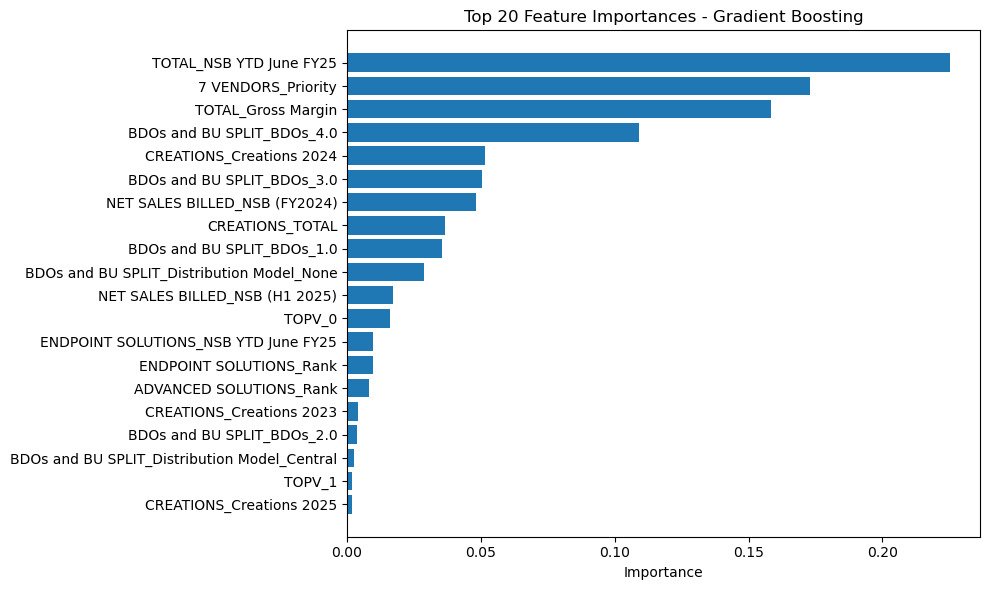

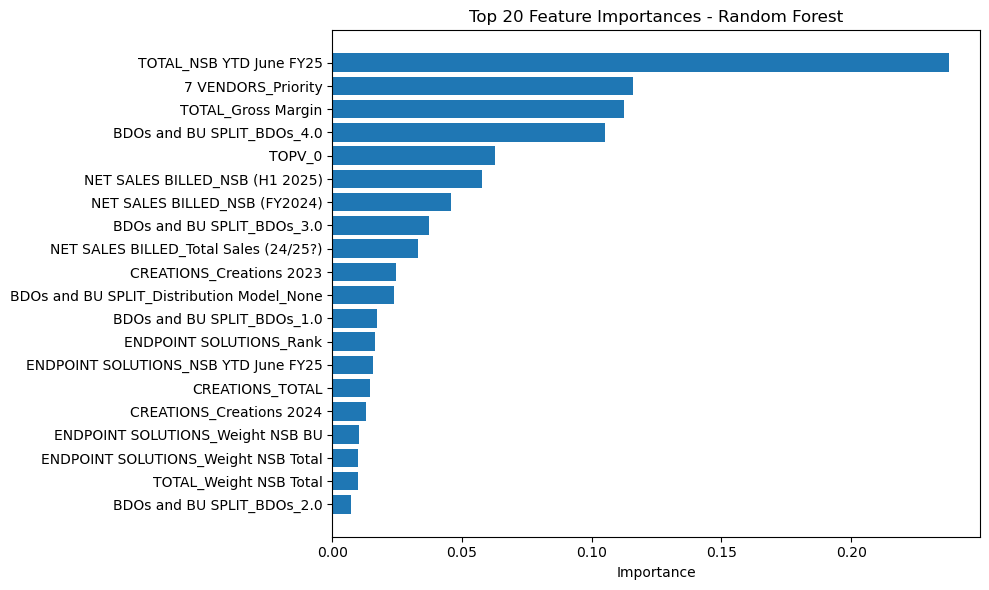

In [18]:
#GB
importances_gb = gbr.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances_gb[indices_gb[:top_n]][::-1])
plt.yticks(range(top_n), X_train.columns[indices_gb[:top_n]][::-1])
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#RF
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances_rf[indices_rf[:top_n]][::-1])
plt.yticks(range(top_n), X_train.columns[indices_rf[:top_n]][::-1])
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

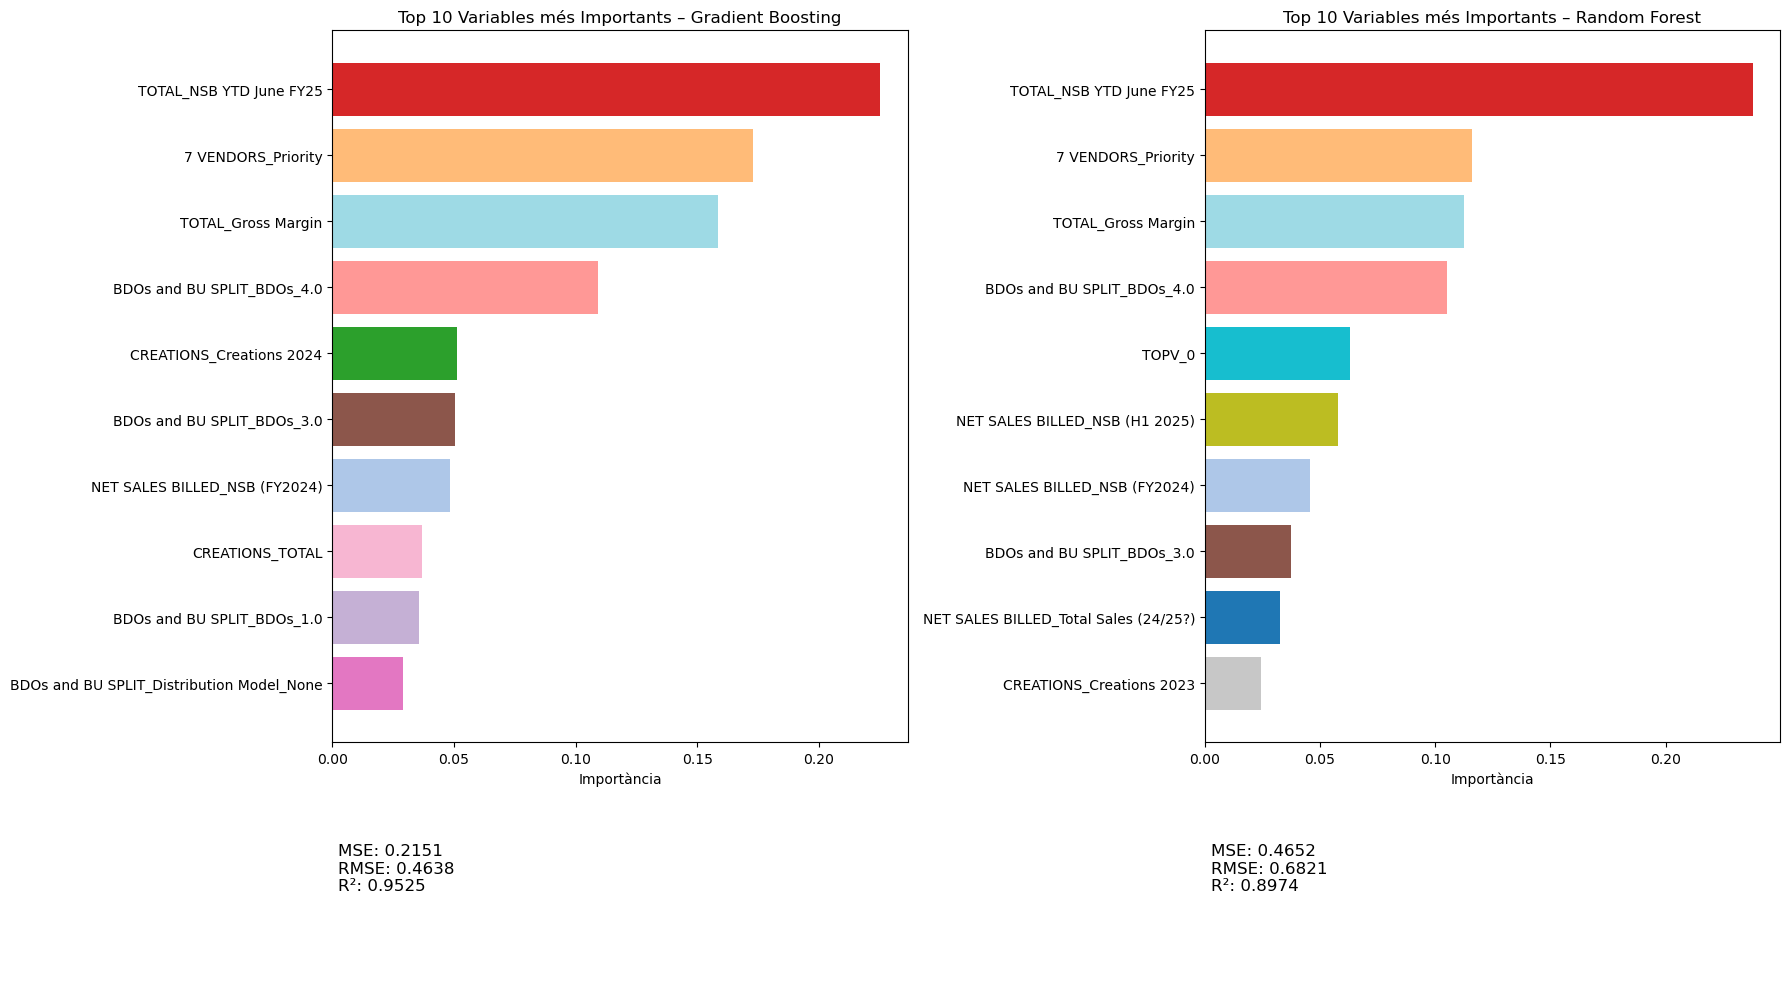

In [19]:
top_n = 10

#Gradient Boosting
importances_gb = gbr.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]
top_gb_features = X_train.columns[indices_gb[:top_n]]
top_gb_values = importances_gb[indices_gb[:top_n]]

#Random Forest
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
top_rf_features = X_train.columns[indices_rf[:top_n]]
top_rf_values = importances_rf[indices_rf[:top_n]]

#mètriques del Gradient Boosting
mse_gb = mean_squared_error(y_test, gbr.predict(X_test))
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, gbr.predict(X_test))

#mètriques del Random Forest
mse_rf = mean_squared_error(y_test, rf.predict(X_test))
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, rf.predict(X_test))

all_top_features = list(set(top_gb_features).union(set(top_rf_features)))

colors = plt.cm.tab20(np.linspace(0, 1, len(all_top_features)))
color_map = {feat: colors[i] for i, feat in enumerate(all_top_features)}

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, height_ratios=[4, 1])

# Gràfic d’importància del Gradient Boosting
ax1 = fig.add_subplot(gs[0, 0])
ax1.barh(
    top_gb_features[::-1],
    top_gb_values[::-1],
    color=[color_map[f] for f in top_gb_features[::-1]]
)
ax1.set_title("Top 10 Variables més Importants – Gradient Boosting")
ax1.set_xlabel("Importància")

# Gràfic d’importància del Random Forest
ax2 = fig.add_subplot(gs[0, 1])
ax2.barh(
    top_rf_features[::-1],
    top_rf_values[::-1],
    color=[color_map[f] for f in top_rf_features[::-1]]
)
ax2.set_title("Top 10 Variables més Importants – Random Forest")
ax2.set_xlabel("Importància")

ax3 = fig.add_subplot(gs[1, 0])
ax3.axis("off")
ax3.text(
    0.01,
    0.5,
    f"MSE: {mse_gb:.4f}\nRMSE: {rmse_gb:.4f}\nR²: {r2_gb:.4f}",
    fontsize=12
)

ax4 = fig.add_subplot(gs[1, 1])
ax4.axis("off")
ax4.text(
    0.01,
    0.5,
    f"MSE: {mse_rf:.4f}\nRMSE: {rmse_rf:.4f}\nR²: {r2_rf:.4f}",
    fontsize=12
)

plt.tight_layout()
plt.show()


In [20]:
top_gb_features = X_train.columns[indices_gb[:10]]

X_train_top10 = X_train[top_gb_features]
X_test_top10 = X_test[top_gb_features]



vlasso = LassoCV(cv=5, random_state=42, max_iter=10000)
vlasso.fit(X_train_top10, y_train)

y_pred_vlasso = vlasso.predict(X_test_top10)


gb_top10 = GradientBoostingRegressor(random_state=42)
gb_top10.fit(X_train_top10, y_train)

y_pred_gb_top10 = gb_top10.predict(X_test_top10)


rf_top10 = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)
rf_top10.fit(X_train_top10, y_train)

y_pred_rf_top10 = rf_top10.predict(X_test_top10)


def mostrar_metrics(nom, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Resultats de {nom}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}\n")

mostrar_metrics("VLasso", y_test, y_pred_vlasso)
mostrar_metrics("Gradient Boosting (top10)", y_test, y_pred_gb_top10)
mostrar_metrics("Random Forest (top10)", y_test, y_pred_rf_top10)


Resultats de VLasso
MSE: 2.4983
RMSE: 1.5806
R²: 0.4489

Resultats de Gradient Boosting (top10)
MSE: 0.3618
RMSE: 0.6015
R²: 0.9202

Resultats de Random Forest (top10)
MSE: 0.4369
RMSE: 0.6609
R²: 0.9036



In [21]:
gbr_base = GradientBoostingRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    estimator=gbr_base,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Millor combinació d’hiperparàmetres:")
print(grid.best_params_)

print("\nR² en train:", grid.best_score_)

gbr_opt = grid.best_estimator_

y_pred_opt = gbr_opt.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse_opt = mean_squared_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_test, y_pred_opt)

print("\nRESULTATS DEL MODEL OPTIMITZAT")
print("MSE:", mse_opt)
print("RMSE:", rmse_opt)
print("R²:", r2_opt)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Millor combinació d’hiperparàmetres:
{'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}

R² en train: 0.9591280555320644

RESULTATS DEL MODEL OPTIMITZAT
MSE: 0.15963191353727746
RMSE: 0.39953962699246426
R²: 0.9647846074369617


In [22]:
# TOP 20 MODEL ORIGINAL
importances_gb_orig = gbr.feature_importances_
indices_gb_orig = np.argsort(importances_gb_orig)[::-1]

top20_orig_features = X_train.columns[indices_gb_orig[:20]]
top20_orig_values = importances_gb_orig[indices_gb_orig[:20]]

print("TOP 20 VARIABLES – MODEL ORIGINAL\n")
for f, v in zip(top20_orig_features, top20_orig_values):
    print(f"{f}: {v}")

# TOP 20 MODEL OPTIMITZAT
importances_gb_opt = gbr_opt.feature_importances_
indices_gb_opt = np.argsort(importances_gb_opt)[::-1]

top20_opt_features = X_train.columns[indices_gb_opt[:20]]
top20_opt_values = importances_gb_opt[indices_gb_opt[:20]]

print("\nTOP 20 VARIABLES – MODEL OPTIMITZAT\n")
for f, v in zip(top20_opt_features, top20_opt_values):
    print(f"{f}: {v}")

# COMPARACIÓ ENTRE MODELS
set_orig = set(top20_orig_features)
set_opt = set(top20_opt_features)

comunes = set_orig.intersection(set_opt)
nomes_original = set_orig - set_opt
nomes_optimitzat = set_opt - set_orig

print("\nVARIABLES COMUNES ALS DOS MODELS:\n")
for x in comunes:
    print(x)

print("\nVARIABLES QUE NOMÉS SURTEN AL MODEL ORIGINAL:\n")
for x in nomes_original:
    print(x)

print("\nVARIABLES QUE NOMÉS SURTEN AL MODEL OPTIMITZAT:\n")
for x in nomes_optimitzat:
    print(x)

TOP 20 VARIABLES – MODEL ORIGINAL

TOTAL_NSB YTD June FY25: 0.22519349933086516
7 VENDORS_Priority: 0.17289939521034117
TOTAL_Gross Margin: 0.15854912089253786
BDOs and BU SPLIT_BDOs_4.0: 0.10914818579119766
CREATIONS_Creations 2024: 0.05139670846358025
BDOs and BU SPLIT_BDOs_3.0: 0.05048582830488256
NET SALES BILLED_NSB (FY2024): 0.048244683231976684
CREATIONS_TOTAL: 0.0367751147403044
BDOs and BU SPLIT_BDOs_1.0: 0.03567471194131977
BDOs and BU SPLIT_Distribution Model_None: 0.02894264190773035
NET SALES BILLED_NSB (H1 2025): 0.01725230911451001
TOPV_0: 0.016157341897230275
ENDPOINT SOLUTIONS_NSB YTD June FY25: 0.009773226995630269
ENDPOINT SOLUTIONS_Rank: 0.009611354431326581
ADVANCED SOLUTIONS_Rank: 0.008063315889211007
CREATIONS_Creations 2023: 0.003939932534621933
BDOs and BU SPLIT_BDOs_2.0: 0.0036210252553999377
BDOs and BU SPLIT_Distribution Model_Central: 0.002646206944789538
TOPV_1: 0.001887551653486586
CREATIONS_Creations 2025: 0.0017398656264716143

TOP 20 VARIABLES – MODEL 

In [23]:
importances = gbr_opt.feature_importances_
indices = np.argsort(importances)[::-1]

top10_features = X_train.columns[indices[:10]]
top10_importances = importances[indices[:10]]

pesos_normalitzats = top10_importances / top10_importances.sum()

df_pesos = pd.DataFrame({
    "variable": top10_features,
    "importancia": top10_importances,
    "pes": pesos_normalitzats
}).sort_values(by="pes", ascending=False)

print("Pesos normalitzats de les top 10 variables:")
display(df_pesos)

def calcular_score_ponderat(row):
    return sum(row[var] * pes for var, pes in zip(top10_features, pesos_normalitzats))

X_train_score = X_train[top10_features].copy()
X_test_score = X_test[top10_features].copy()

X_train_score["score_ponderat"] = X_train_score.apply(calcular_score_ponderat, axis=1)
X_test_score["score_ponderat"] = X_test_score.apply(calcular_score_ponderat, axis=1)


Pesos normalitzats de les top 10 variables:


,variable,importancia,pes
0,7 VENDORS_Priority,0.194243,0.223453
1,TOTAL_Gross Margin,0.160333,0.184443
2,TOPV_0,0.118423,0.136231
3,BDOs and BU SPLIT_BDOs_1.0,0.114889,0.132166
4,BDOs and BU SPLIT_BDOs_4.0,0.070184,0.080738
5,BDOs and BU SPLIT_BDOs_2.0,0.057694,0.066370
6,TOTAL_NSB YTD June FY25,0.050767,0.058401
7,CREATIONS_TOTAL,0.037221,0.042818
8,NET SALES BILLED_NSB (H1 2025),0.032864,0.037806
9,CREATIONS_Creations 2024,0.032661,0.037573


In [51]:
list(zip(X_train.columns, gbr_opt.feature_importances_))


[('CREATIONS_Creations 2025', 0.009539134988973682),
 ('CREATIONS_Creations 2024', 0.032661486571417736),
 ('CREATIONS_Creations 2023', 0.004983199074550961),
 ('CREATIONS_TOTAL', 0.03722112892819186),
 ('NET SALES BILLED_NSB (H1 2025)', 0.03286354258830031),
 ('NET SALES BILLED_NSB (FY2024)', 0.014799518514741695),
 ('NET SALES BILLED_Total Sales (24/25?)', 0.021934163468914566),
 ('NET SALES BILLED_NSB/Creation', 6.827238320857955e-05),
 ('BDOs and BU SPLIT_AS ', 1.5769103545521337e-05),
 ('BDOs and BU SPLIT_EPS', 2.770527098251745e-06),
 ('BDOs and BU SPLIT_SPS', 2.614579190777111e-06),
 ('BDOs and BU SPLIT_S&C', 8.13239058396151e-06),
 ('BDOs and BU SPLIT_Other', 0.0),
 ('7 VENDORS_Priority', 0.1942427969415465),
 ('TOTAL_NSB YTD June FY25', 0.05076683912335433),
 ('TOTAL_Weight NSB Total', 0.009700205500084274),
 ('TOTAL_Gross Margin', 0.16033276766582938),
 ('ADVANCED SOLUTIONS_NSB YTD June FY25', 0.000255813127619025),
 ('ADVANCED SOLUTIONS_Rank', 4.2360637792890313e-05),
 ('ADV

,pes_original,pes_ml
Creations 2025,0.100,0.000000
Creations TOTAL,0.100,0.073401
NSB H1 2025,0.085,0.064807
NSB 24/25,0.085,0.000000
Priority,0.300,0.383050
BDO Priority,0.250,0.478742
Distribution Model,0.080,0.000000


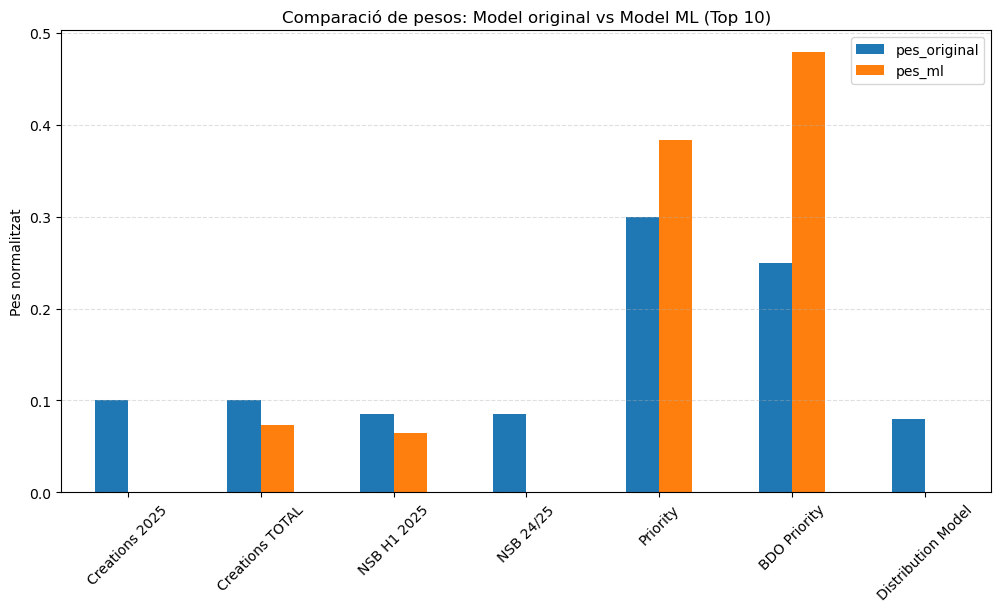

In [49]:
# 1. PESOS ORIGINALS DEFINITS DEL MODEL DE NEGOCI

pesos_originals = {
    "Creations 2025": 0.1,
    "Creations TOTAL": 0.1,
    "NSB H1 2025": 0.085,
    "NSB 24/25": 0.085,
    "Priority": 0.3,
    "BDO Priority": 0.25,
    "Distribution Model": 0.08
}

# 2. AGAFEM AUTOMÀTICAMENT ELS PESOS ML DEL TEU df_pesos

pesos_ml_full = dict(zip(df_pesos["variable"], df_pesos["pes"]))

# 3. CORRESPONDÈNCIES AUTOMÀTIQUES ORIGINAL ↔ ML

def pes(var): 
    return pesos_ml_full.get(var, 0)

pesos_ml_equivalents = {
    "Creations 2025": pes("CREATIONS_Creations 2025"),
    "Creations TOTAL": pes("CREATIONS_TOTAL"),
    "NSB H1 2025": pes("NET SALES BILLED_NSB (H1 2025)"),
    "NSB 24/25": pes("NET SALES BILLED_Total Sales (24/25?)"),
    "Priority": pes("7 VENDORS_Priority"),

    "BDO Priority": (
        pes("BDOs and BU SPLIT_BDOs_1.0") +
        pes("BDOs and BU SPLIT_BDOs_2.0") +
        pes("BDOs and BU SPLIT_BDOs_4.0")
    ),

    "Distribution Model": sum(
        val for key, val in pesos_ml_full.items()
        if "BDOs and BU SPLIT_Distribution Model" in key
    )
}

# 4. NORMALITZEM ELS PESOS ML PERQUÈ SUMIN 1

suma = sum(pesos_ml_equivalents.values())
pesos_ml_norm = {k: v / suma for k, v in pesos_ml_equivalents.items()}

# 5. DATAFRAME COMPARATIU

df_comp = pd.DataFrame({
    "pes_original": pesos_originals,
    "pes_ml": pesos_ml_norm
})

display(df_comp)

# 6. GRÀFIC COMPARATIU

df_comp.plot(kind="bar", figsize=(12, 6))
plt.title("Comparació de pesos: Model original vs Model ML (Top 10)")
plt.ylabel("Pes normalitzat")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


,pes_original,pes_ml_global
Creations 2025,0.100,0.016909
Creations TOTAL,0.100,0.065979
NSB H1 2025,0.085,0.058255
NSB 24/25,0.085,0.038881
Priority,0.300,0.344319
BDO Priority,0.250,0.430335
Distribution Model,0.080,0.045322


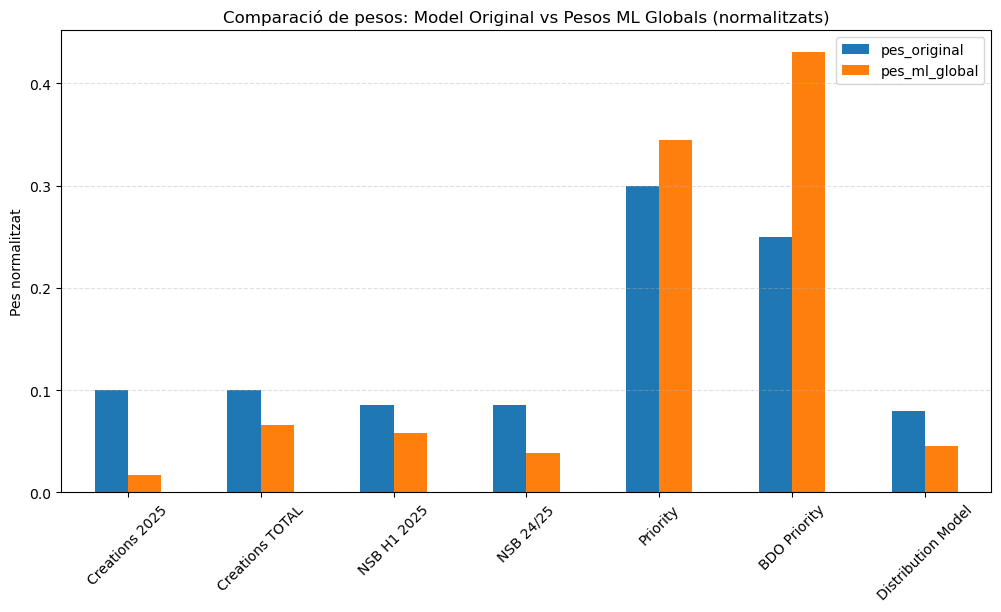

In [55]:
# 1) Importàncies globals des del model ML
llista = list(zip(X_train.columns, gbr_opt.feature_importances_))
df_full = pd.DataFrame(llista, columns=["variable", "importancia"])
df_full["pes_global"] = df_full["importancia"] / df_full["importancia"].sum()

# 2) Pesos originals (ja normalitzats)
pesos_originals = {
    "Creations 2025": 0.1,
    "Creations TOTAL": 0.1,
    "NSB H1 2025": 0.085,
    "NSB 24/25": 0.085,
    "Priority": 0.3,
    "BDO Priority": 0.25,
    "Distribution Model": 0.08
}

# 3) Correspondències ML -> variables originals
corresp = {
    "Creations 2025": ["CREATIONS_Creations 2025"],
    "Creations TOTAL": ["CREATIONS_TOTAL"],
    "NSB H1 2025": ["NET SALES BILLED_NSB (H1 2025)"],
    "NSB 24/25": ["NET SALES BILLED_Total Sales (24/25?)"],
    "Priority": ["7 VENDORS_Priority"],
    "BDO Priority": [
        "BDOs and BU SPLIT_BDOs_1.0",
        "BDOs and BU SPLIT_BDOs_2.0",
        "BDOs and BU SPLIT_BDOs_4.0"
    ],
    "Distribution Model": [
        var for var in df_full["variable"]
        if "BDOs and BU SPLIT_Distribution Model" in var
    ]
}

# 4) Pesos globals ML SUMATS per correspondència
pesos_ml_globals_raw = {
    nom: df_full.loc[df_full["variable"].isin(vars_ml), "pes_global"].sum()
    for nom, vars_ml in corresp.items()
}

# 5) Normalització correcta (només per als 7 pesos originals)
suma_globals = sum(pesos_ml_globals_raw.values())
pesos_ml_globals = {k: v / suma_globals for k, v in pesos_ml_globals_raw.items()}

# 6) DataFrame final comparatiu
df_global_comp = pd.DataFrame({
    "pes_original": pesos_originals,
    "pes_ml_global": pesos_ml_globals
})

display(df_global_comp)

# 7) Gràfic comparatiu
df_global_comp.plot(kind="bar", figsize=(12,6))
plt.title("Comparació de pesos: Model Original vs Pesos ML Globals (normalitzats)")
plt.ylabel("Pes normalitzat")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

,Original,Top10 ML,Global ML
Creations 2025,0.100,0.000000,0.016909
Creations TOTAL,0.100,0.073401,0.065979
NSB H1 2025,0.085,0.064807,0.058255
NSB 24/25,0.085,0.000000,0.038881
Priority,0.300,0.383050,0.344319
BDO Priority,0.250,0.478742,0.430335
Distribution Model,0.080,0.000000,0.045322


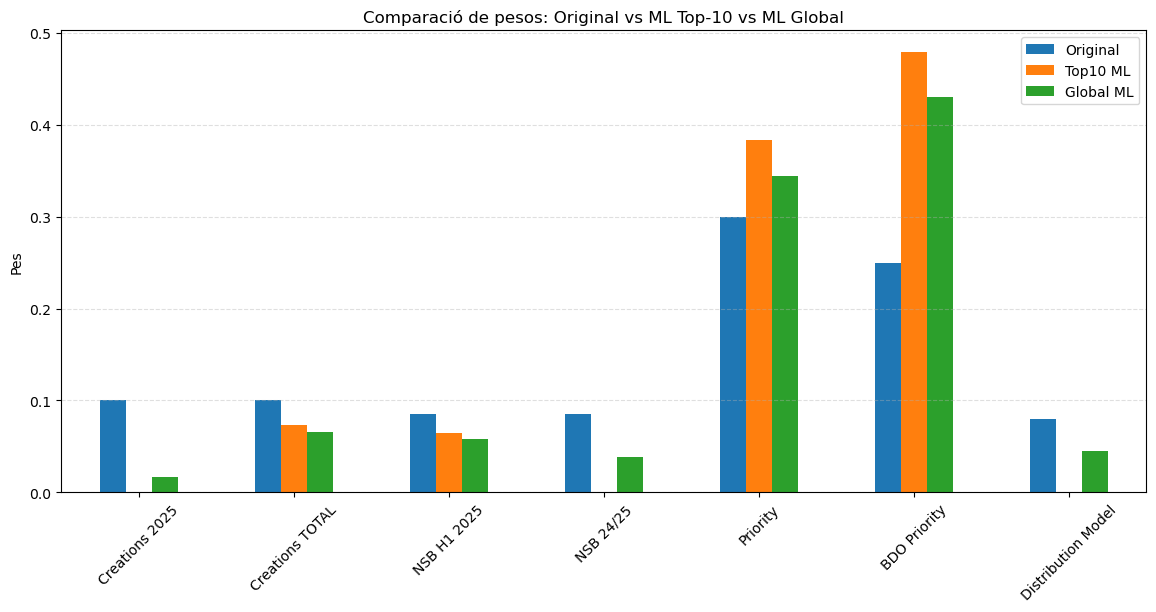

In [57]:
pesos_originals = {
    "Creations 2025": 0.1,
    "Creations TOTAL": 0.1,
    "NSB H1 2025": 0.085,
    "NSB 24/25": 0.085,
    "Priority": 0.3,
    "BDO Priority": 0.25,
    "Distribution Model": 0.08
}

pesos_ml_top10 = dict(zip(df_pesos["variable"], df_pesos["pes"]))
def pes_top10(v): return pesos_ml_top10.get(v, 0)

pesos_top10_equivalents = {
    "Creations 2025": pes_top10("CREATIONS_Creations 2025"),
    "Creations TOTAL": pes_top10("CREATIONS_TOTAL"),
    "NSB H1 2025": pes_top10("NET SALES BILLED_NSB (H1 2025)"),
    "NSB 24/25": pes_top10("NET SALES BILLED_Total Sales (24/25?)"),
    "Priority": pes_top10("7 VENDORS_Priority"),
    "BDO Priority": (
        pes_top10("BDOs and BU SPLIT_BDOs_1.0") +
        pes_top10("BDOs and BU SPLIT_BDOs_2.0") +
        pes_top10("BDOs and BU SPLIT_BDOs_4.0")
    ),
    "Distribution Model": 0
}

s_top10 = sum(pesos_top10_equivalents.values())
pesos_top10_norm = {k: v / s_top10 for k, v in pesos_top10_equivalents.items()}

llista = list(zip(X_train.columns, gbr_opt.feature_importances_))
df_full = pd.DataFrame(llista, columns=["variable", "importancia"])
df_full["pes_global"] = df_full["importancia"] / df_full["importancia"].sum()

corresp = {
    "Creations 2025": ["CREATIONS_Creations 2025"],
    "Creations TOTAL": ["CREATIONS_TOTAL"],
    "NSB H1 2025": ["NET SALES BILLED_NSB (H1 2025)"],
    "NSB 24/25": ["NET SALES BILLED_Total Sales (24/25?)"],
    "Priority": ["7 VENDORS_Priority"],
    "BDO Priority": [
        "BDOs and BU SPLIT_BDOs_1.0",
        "BDOs and BU SPLIT_BDOs_2.0",
        "BDOs and BU SPLIT_BDOs_4.0"
    ],
    "Distribution Model": [
        v for v in df_full["variable"]
        if "BDOs and BU SPLIT_Distribution Model" in v
    ]
}

pesos_ml_global_raw = {
    nom: df_full.loc[df_full["variable"].isin(vars_ml), "pes_global"].sum()
    for nom, vars_ml in corresp.items()
}

s_global = sum(pesos_ml_global_raw.values())
pesos_ml_global = {k: v / s_global for k, v in pesos_ml_global_raw.items()}

df_triple = pd.DataFrame({
    "Original": pesos_originals,
    "Top10 ML": pesos_top10_norm,
    "Global ML": pesos_ml_global
})

display(df_triple)

df_triple.plot(kind="bar", figsize=(14,6))
plt.xticks(rotation=45)
plt.ylabel("Pes")
plt.title("Comparació de pesos: Original vs ML Top-10 vs ML Global")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()
